# Law, Order, and Algorithms

## Estimating San Francisco surveillance camera density

In [1]:
# uncomment this line if have problems loading the libraries 
# install.packages(c("sf", "ggmap"))
library(tidyverse)
library(sf)
library(ggmap) # shouldn't need to add API key as I pre-saved the ggmap

theme_set(theme_bw(base_size = 14))
# suppress warnings
options(warn = -1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.8.1, GDAL 3.1.4, PROJ 6.3.1

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.



In this lab, we are going to replicate results from the paper [Sheng et al. (2021)](https://5harad.com/papers/surveilling-surveillance.pdf) where they estimate the prevalence of surveillance cameras across the US using Google street view data.

Specifically, we will perform two tasks in this lab:
1) Estimate surveillance camera density in San Francisco;
2) Examine whether the camera density is correlated with the share of minority population.

### Data

In [9]:
# Load data
load(file = "../data/surveillance_sf.RData")

We are loading three objects into the notebook, they are

#### cameras_sf
(row per image, only allow one detection per image)
- `panoid`: ID of image 
- `lat-lon`: coordinates of image
- `period`: year of image
- `detected`, `verified`

#### census_sf
(row per census block group)
- `GEOID`, `NAME`: ID and name of census block group
- `total_pop`: total population of CBG
- `total_white`: total non-Hispanic white population of CBG
- `geometry`: multipolygon shape of census block group

#### ggmap_sf
- saved ggmap of San Francisco

#### cameras_all
(row per image, only allow one detection per image)
- pre-cleaned file, variables should be self-explanatory

### Object detection models

In order to indentify cameras using street view images, we need to use a [object detection](https://en.wikipedia.org/wiki/Object_detection) model.
An object detection model is a computer vision model that detects instances of objects of a certain class within an image.
In this particular case we are interested in detecting cameras in an image, but in practice such model can be used to detec all kinds of objects.

While object detection models' performance has increased drastically thanks to the rise of deep learning, enabling a number of previously impossible applications, they are not perfect models.
In order to understand how well the camera detection model works, we evaluate it using two useful metrics: [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

In our camera detection application, the existance of a camera is considered to be "positive".
Given a dataset of camera detection prediction produced by our object detection model and the corresponding ground truth labels verified by humans, we can define the following terms:

* P: the number of real positive cases in the data
* N: the number of real negative cases in the data
* TP: true positives; the number of predicted positive cases that were real positives 
* TN: true negatives; the number of predicted negative cases that were real negatives 
* FP: false positives; the number of predicted positives that were actually negative in the data (false alarms, Type I error)
* FN: false negatives; the number of predicted negatives that were actually positive in the data (Type II error) 

Their definitions can be illustrated using following table:

<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0; margin: auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#BBBBBB;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#BBBBBB;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-baqh">Real positive</th>
    <th class="tg-baqh">Real negative</th>
  </tr>
  <tr>
    <td class="tg-baqh">Predicted positive</td>
    <td class="tg-baqh">TP</td>
    <td class="tg-baqh">FP</td>
  </tr>
  <tr>
    <td class="tg-baqh">Predicted negative</td>
    <td class="tg-baqh">FN</td>
    <td class="tg-baqh">TN</td>
  </tr>
</table>
<br>


Precision is defined as
$\frac{TP}{TP + FP} = \frac{N_{\text{correctly identified cameras}}}{N_{\text{identified cameras}}}$

Recall is defined as
$\frac{TP}{TP + FN} = \frac{N_{\text{correctly identified cameras}}}{N_{\text{real cameras}}}$


This diagram from Wikipedia visually illustrates their definitions:

![Precision and recall](../images/precision_recall.png)


#### Exercise: calculate model precision
As an exercise, let's calculate the precision of our model using columns `verified` and `detected` from the data frame `cameras_sf`.

In [23]:
# Your code here!
# START solution
cameras_sf %>%
  summarize(precision = sum(verified) / sum(detected))
# END solution

precision
<dbl>
0.4255319


### Estimate surveillance camera detections and density in San Francisco

As we see above, both the model's precision and recall are far from perfect.
However, we are still able to use this model to help us estimate the number of cameras in SF.

By running the camera detection model on a sample of street view images (in `cameras_sf`), we can estimate the total number of cameras in SF using three ingredients:
1) The number of verified cameras in this sample
2) Model recall
3) Percentage of all roads in SF covered by the sample

By running the camera detection model on a random sample of positive instances (i.e., images with cameras), we are able to obtain its recall of 0.67.
Now let's calculate 1) and 3).

#### Exercise: calculate the number of verified cameras

In [26]:
# Calculate the number of verified cameras: n_verified
# Your code here!
# START solution
n_verified <- sum(cameras_sf$verified)
# END solution
n_verified

[1] 40

#### Exercise: calculate percentage of all roads in SF covered by the sample

In [27]:
# Constants
# Total road length in San Francisco (meter)
road_length_m <- 3108000
# Average length of road covered by one image in the dataset meter
avg_image_length_m <- 24.140665298930312

# Calculate percentage of all roads in SF covered by the sample: perc_road_covered
# Your code here!
# START solution
n_images <- nrow(cameras_sf)
perc_road_covered <- avg_image_length_m * n_images / (2 * road_length_m)
# END solution

perc_road_covered

[1] 0.01941817

Now we are able to estimate the total number of cameras in SF.
#### Exercise: derive the formula and calculate the estimated number of cameras in SF

In [28]:
# Constants
# Recall of the camera detection model
recall <- 0.67

# Estimate camera detections and density
# Your code here!
# START solution
est_cameras <- n_verified * (1 / recall) * (1 / perc_road_covered)
# END solution

est_cameras

[1] 3074.517

And subsequently, we can calculate the camera density as follows:

In [30]:
est_cameras_per_km <- est_cameras * 1000 / road_length_m
est_cameras_per_km

[1] 0.989227

### Plot camera detections on map
We can plot the locations of detected cameras in our sample on map

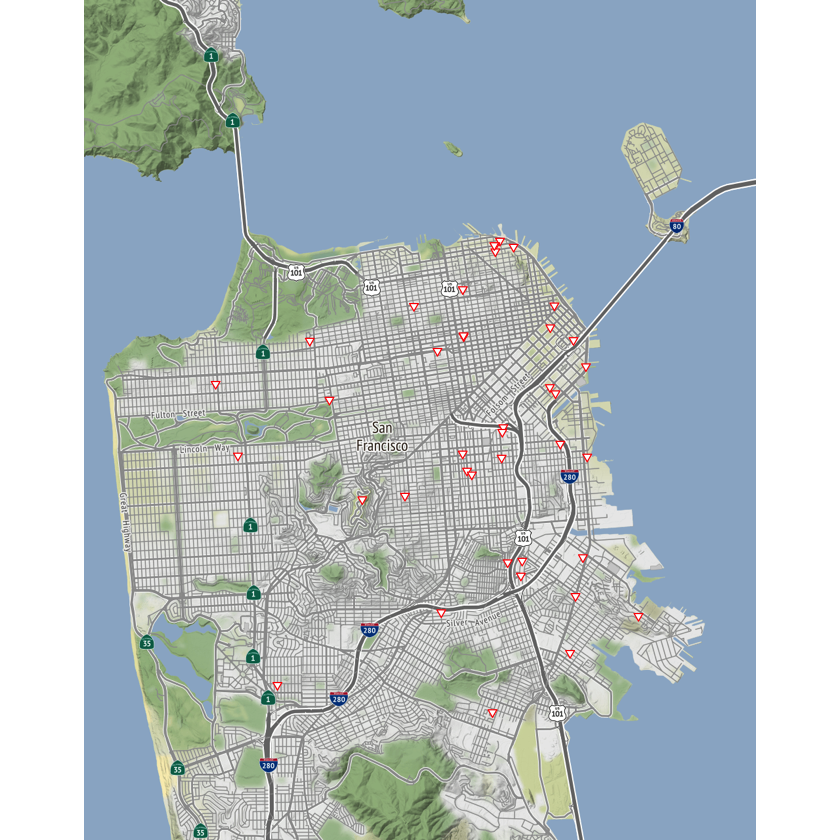

In [31]:
ggmap(ggmap_sf, extent = "device") +
  geom_point(data = cameras_sf %>% 
               filter(verified),
             aes(x = lon, y = lat),
             position = "jitter", 
             shape = 25, fill = "white", color = "red",
             alpha = 1, size = 1.5) +
  theme(axis.text = element_blank(), 
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank())

### Plot detection rate against minority share for all cities
By performing the analysis above for multiple cities across the US and combining the results with census data,
we are able to plot the relationship between camera density and share of minorities in that location.

[Discuss: what do we see here?]

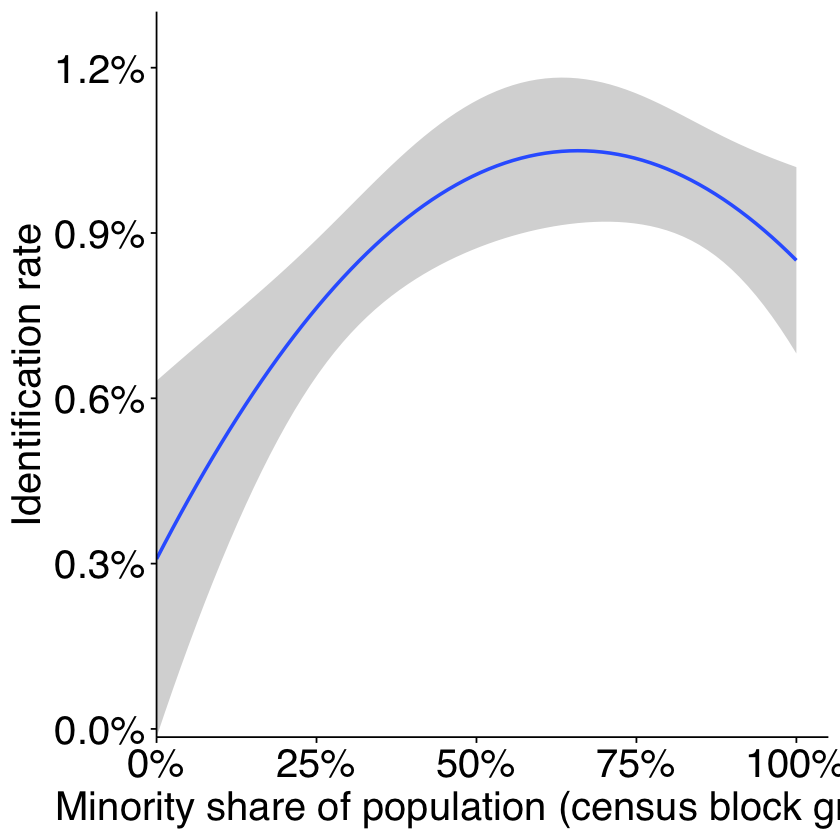

In [32]:
cameras_all %>%
  ggplot(aes(x = percentage_minority, y = verified)) +
  #geom_hline(yintercept = avg_detection_rate, linetype = "dashed", color = "gray") + # avg detection rate
  geom_smooth(method = "lm", 
              formula = y ~ poly(x, degree = 2),
              se = T) +
  scale_x_continuous(
    name = "Minority share of population (census block group)", 
    #breaks = seq(0, 1, 0.1),
    expand = expansion(mult = c(0, 0.05)),
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_y_continuous(
    name = "Identification rate",  
    breaks = seq(0, 0.012, 0.003),
    expand = expansion(mult = c(0, 0.1)),
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  theme(
    panel.grid = element_blank(),
    panel.border = element_blank(),
    axis.text = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.title = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.line = element_line(size = 0.5, color = "black"),
    axis.ticks.x = element_line(size = 0.5, color = "black"),
    axis.ticks.y = element_line(size = 0.5, color = "black")
  ) 

## ===== everything below can be dropped =====
### Plot detection rate against minority share (SF only)

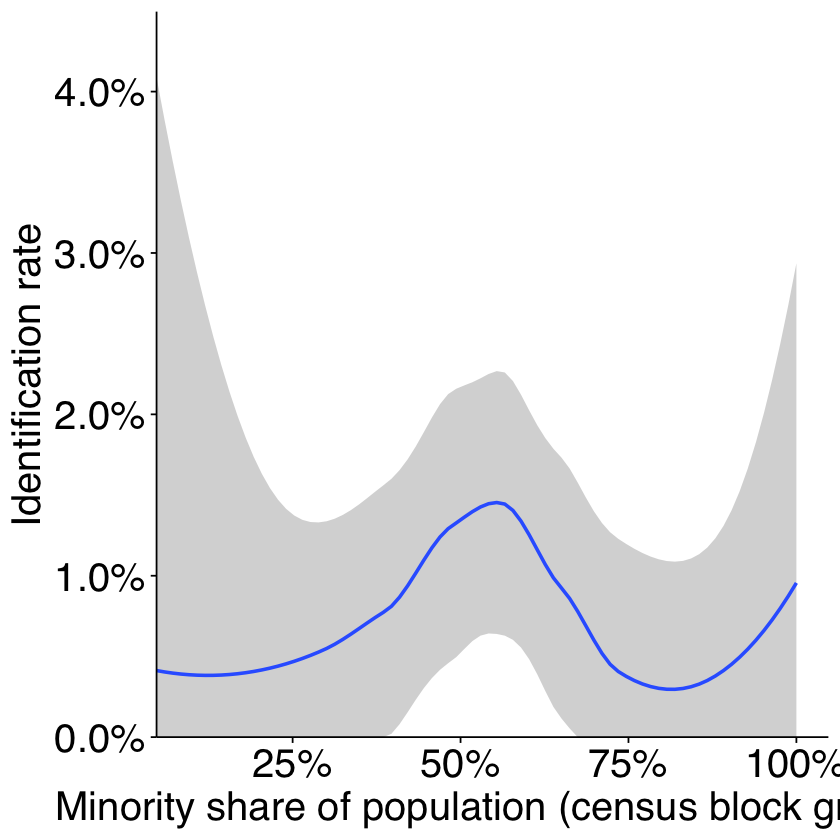

In [4]:
# NB: 
# - Plotting rates for each census block group instead of for each image.
# - These plots don't look great due to the low number of points.
df_sf <- st_join(
    census_sf %>%
      mutate(percentage_minority = (total_pop - total_white) / total_pop),
    cameras_sf %>%
      st_as_sf(coords = c("lon", "lat"),
               crs = 4269, # ensure same coords as tidycensus
               agr = "constant")
  ) %>%
  group_by(GEOID) %>%
  summarize(percentage_minority = first(percentage_minority),
            detection_rate = sum(verified) / n()) %>% 
  suppressMessages()

df_sf %>%
  ggplot(aes(x = percentage_minority, y = detection_rate)) +
  # Different modelling options: 
  #geom_point() +
  geom_smooth(formula='y ~ x', method = 'loess') +
  # geom_smooth(method = "lm",
  #             formula = y ~ poly(x, degree = 2),
  #             se = T) +
  scale_x_continuous(
    name = "Minority share of population (census block group)", 
    expand = expansion(mult = c(0, 0.05)),
    labels = scales::percent_format(accuracy = 1)
  ) +
  scale_y_continuous(
    name = "Identification rate",  
    limits = c(0, NA),
    oob = scales::squish,
    expand = expansion(mult = c(0, 0.1)),
    labels = scales::percent_format(accuracy = 0.1)
  ) +
  theme(
    panel.grid = element_blank(),
    panel.border = element_blank(),
    axis.text = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.title = element_text(size = 24, family = "Helvetica", color = "black"),
    axis.line = element_line(size = 0.5, color = "black"),
    axis.ticks.x = element_line(size = 0.5, color = "black"),
    axis.ticks.y = element_line(size = 0.5, color = "black")
  ) 

### Plot camera detection rate as heatmap in SF

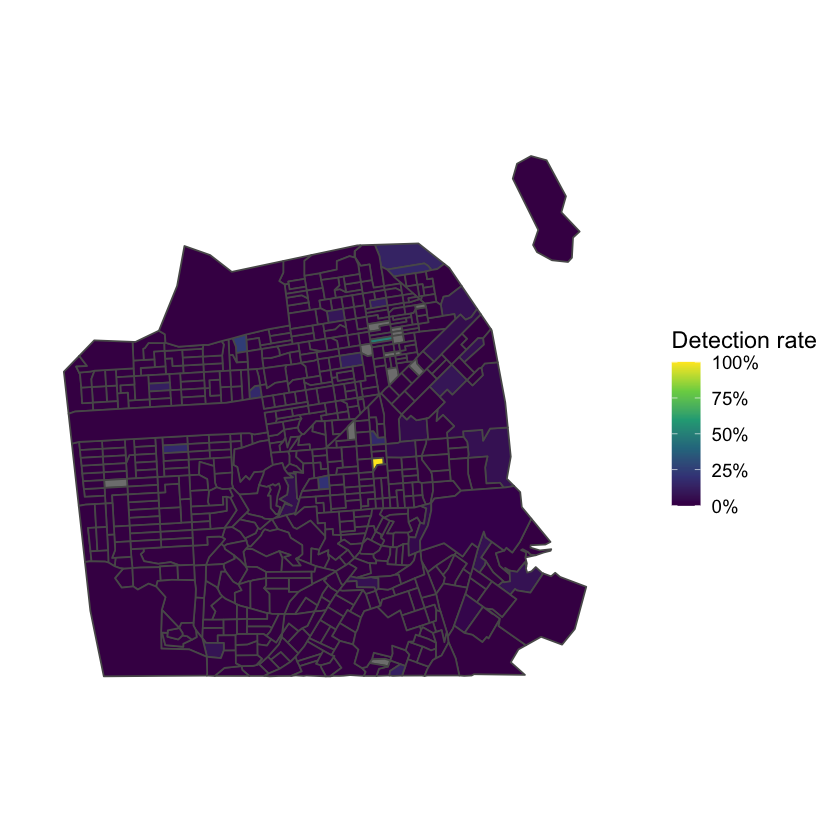

In [60]:
ggplot(df_sf, aes(fill = detection_rate)) +
  geom_sf() +
  scale_x_continuous(limits = c(-122.52, -122.35)) +
  scale_y_continuous(limits = c(37.7, 37.84)) +
  scale_fill_viridis_c("Detection rate", labels = scales::percent) +
  theme(axis.text = element_blank(), 
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank())